<a href="https://colab.research.google.com/github/AroojArifNU/DLTest/blob/main/Colab_Notebooks%20/FoolBoX_Library(Attacks_Comparison)_V8(all_epsilon).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install FoolBox Library**

In [2]:
!pip install foolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


# **Count the occurrences of each correct label in the test set**

In [3]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import foolbox as fb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your trained model
print("Loading model...")
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')

# Load and preprocess the examples
print("Loading data...")
correct_examples = np.load('/content/drive/MyDrive/ColabNotebooks/correct_examples.npy')
correct_labels = np.load('/content/drive/MyDrive/ColabNotebooks/correct_labels.npy').astype('int32')

# Calculate accuracy on clean data
predictions = model.predict(correct_examples).argmax(axis=-1)
accuracy_clean = np.mean(predictions == correct_labels)
print(f"Accuracy on clean data: {accuracy_clean * 100:.2f}%")



# Count the occurrences of each label in the test set
unique, counts = np.unique(correct_labels, return_counts=True)
correct_labels_counts = dict(zip(unique, counts))
print("occurrences of each label:", correct_labels_counts)
for label, count in correct_labels_counts.items():
    print(f"Label {label}: {count}")

Loading model...
Loading data...
308/308 [==============================] - 3s 9ms/step
Accuracy on clean data: 100.00%
occurrences of each label: {0: 973, 1: 1133, 2: 1016, 3: 989, 4: 969, 5: 882, 6: 937, 7: 1005, 8: 946, 9: 984}
Label 0: 973
Label 1: 1133
Label 2: 1016
Label 3: 989
Label 4: 969
Label 5: 882
Label 6: 937
Label 7: 1005
Label 8: 946
Label 9: 984


# **AdditiveUniformNoise & PGD & FastGradientAttack Attack**

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Performing AdditiveUniformNoise attack...
308/308 [==============================] - 5s 14ms/step
Accuracy on clean data: 100.00%
Processing epsilon 0.01...
308/308 [==============================] - 2s 5ms/step
Accuracy on AdditiveUniformNoise adversarial data with epsilon 0.01: 99.97%
308/308 [==============================] - 2s 5ms/step
Processing epsilon 0.02...
308/308 [==============================] - 2s 5ms/step
Accuracy on AdditiveUniformNoise adversarial data with epsilon 0.02: 99.94%
308/308 [==============================] - 1s 5ms/step
Processing epsilon 0.03...
308/308 [==============================] - 2s 7ms/step
Accuracy on AdditiveUniformNoise adversarial data with epsilon 0.03: 99.92%
308/308 [==============================] - 3s 8ms/step
Processing epsilon 0.04...
308/308 [==============================] - 1s 5ms/step
Accuracy on AdditiveUniformNoise adversarial data with epsilon 0.04: 99.90%
308/308 [==============================] - 1s 5ms/step
Processing epsilon

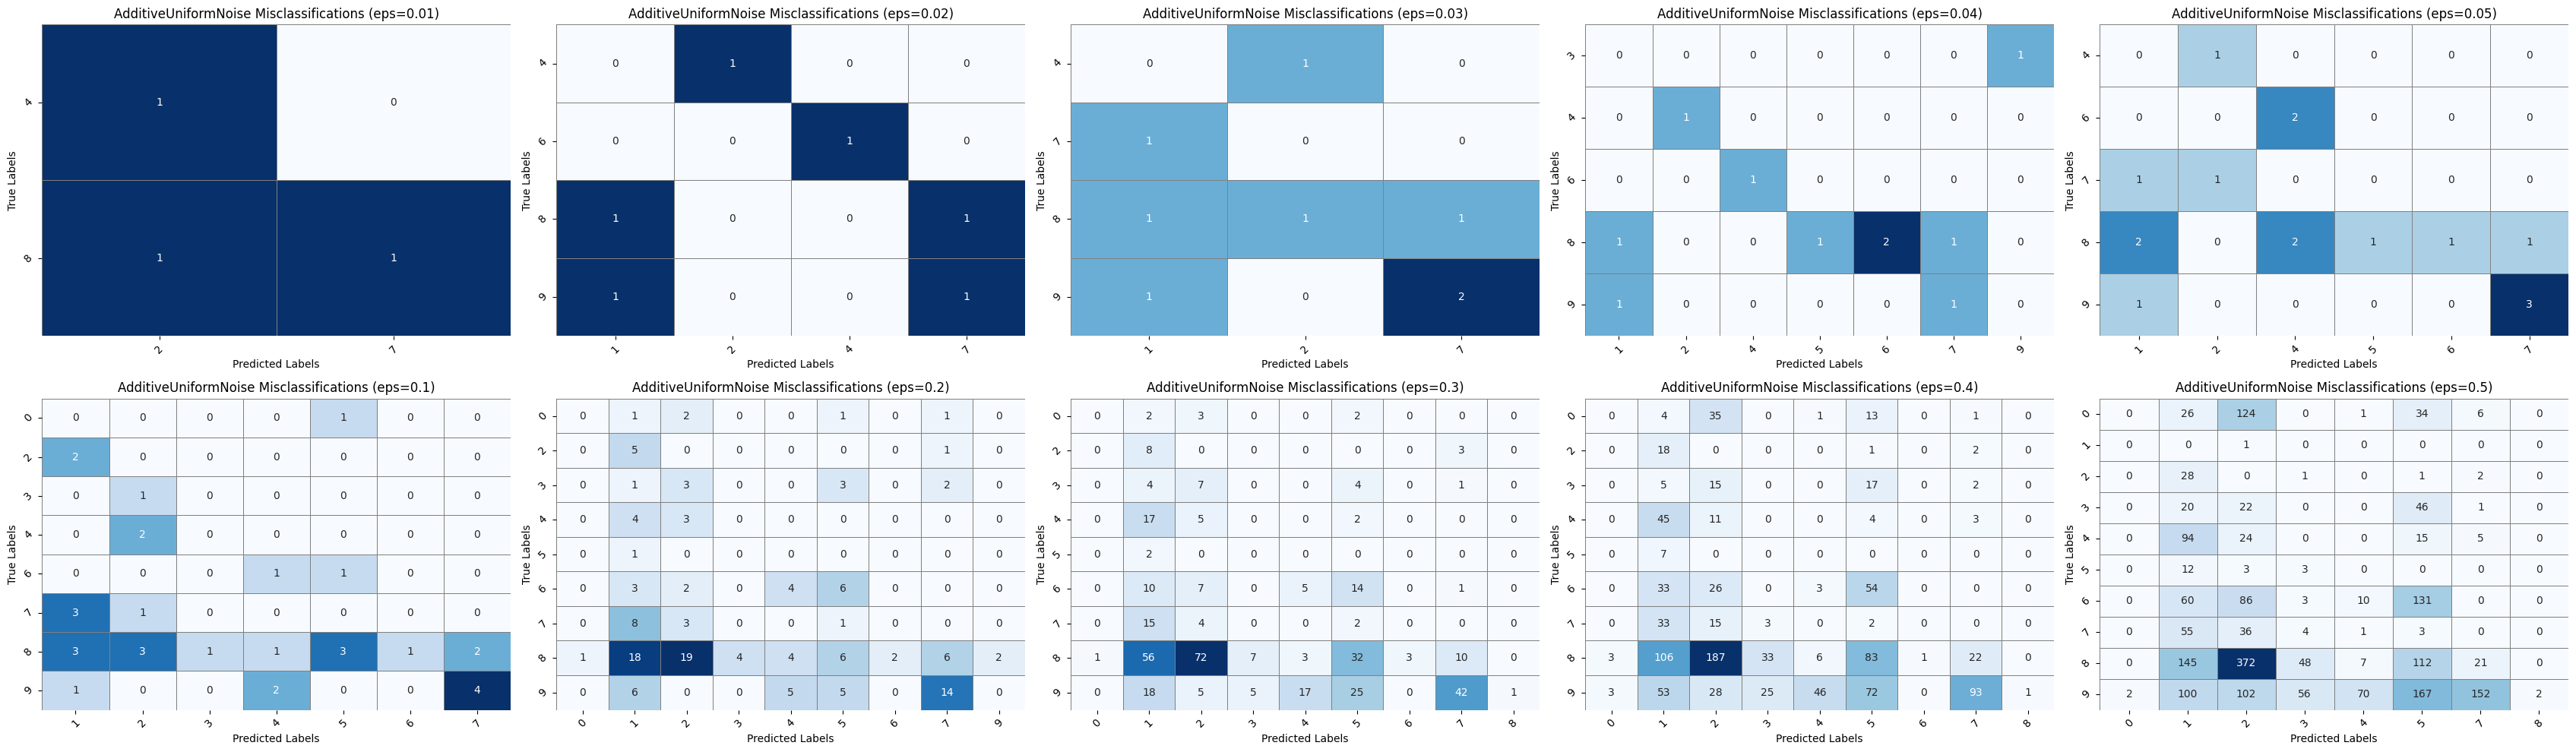

Performing PGD attack...
308/308 [==============================] - 2s 7ms/step
Accuracy on clean data: 100.00%


In [ ]:


# Convert data to TensorFlow tensors
images = tf.convert_to_tensor(correct_examples)
labels = tf.convert_to_tensor(correct_labels, dtype=tf.int32)

# Create a Foolbox model for TensorFlow
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Define epsilons
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Function to perform an attack, plot results, and return attack data
def perform_attack(attack, attack_name):
    print(f"Performing {attack_name} attack...")

    # Calculate accuracy on clean data
    predictions = model.predict(correct_examples).argmax(axis=-1)
    accuracy_clean = np.mean(predictions == correct_labels)
    print(f"Accuracy on clean data: {accuracy_clean * 100:.2f}%")

    raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilons)

    num_classes = 10
    fig, axs = plt.subplots(2, 5, figsize=(34, 10))

    for i, (eps, advs_) in enumerate(zip(epsilons, clipped_advs)):
        ax = axs[i // 5, i % 5]
        print(f"Processing epsilon {eps}...")

        adv_predictions = model.predict(advs_).argmax(axis=-1)
        accuracy_adv = np.mean(adv_predictions == correct_labels)
        print(f"Accuracy on {attack_name} adversarial data with epsilon {eps}: {accuracy_adv * 100:.2f}%")

        y_adv = np.argmax(model.predict(advs_), axis=1)
        cm = confusion_matrix(correct_labels, y_adv, labels=range(num_classes))
        np.fill_diagonal(cm, 0)
        non_zero_rows = np.any(cm != 0, axis=1)
        non_zero_cols = np.any(cm != 0, axis=0)
        filtered_cm = cm[non_zero_rows][:, non_zero_cols]

        sns.heatmap(filtered_cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=.5, linecolor='grey')
        ax.set_title(f'{attack_name} Misclassifications (eps={eps})')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_xticklabels(np.arange(num_classes)[non_zero_cols], rotation=45)
        ax.set_yticklabels(np.arange(num_classes)[non_zero_rows], rotation=45)

    plt.tight_layout()
    plt.savefig(f'{attack_name}_misclassifications_subplot.png')
    plt.show()

    attack_results = {
        'raw_advs': raw_advs,
        'clipped_advs': clipped_advs,
        'success': success
    }

    return attack_results


# Perform Brendel & Bethge attack

additive_results = perform_attack(fb.attacks.LinfAdditiveUniformNoiseAttack(), "AdditiveUniformNoise")

# Perform PGD attack
pgd_results = perform_attack(fb.attacks.LinfPGD(), "PGD")

# Perform Boundary attack
guassian_results = perform_attack(fb.attacks.LinfFastGradientAttack(), "FastGradientAttack")

# Now bb_results,pgd_results and boundary_results contain the raw_advs, clipped_advs, and success for each attack


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming epsilons, pgd_results, and guassian_results are defined from previous attacks

# Calculate robust accuracy for PGD attack
pgd_success = pgd_results['success']
robust_accuracy_pgd = 1 - tf.reduce_mean(tf.cast(pgd_success, tf.float32), axis=-1)
print("Robust accuracy for PGD perturbations:")
for eps, acc in zip(epsilons, robust_accuracy_pgd):
    print(f"  Linf norm ≤ {eps:<6}: {acc.numpy() * 100:4.1f} %")

# Calculate robust accuracy for additive_results attack
additive_success = additive_results['success']
robust_accuracy_additive = 1 - tf.reduce_mean(tf.cast(additive_success, tf.float32), axis=-1)
print("Robust accuracy for Additive perturbations:")
for eps, acc in zip(epsilons, robust_accuracy_additive):
    print(f"  Linf norm ≤ {eps:<6}: {acc.numpy() * 100:4.1f} %")


# Calculate robust accuracy for Guassian attack
guassian_success = guassian_results['success']
robust_accuracy_guassian = 1 - tf.reduce_mean(tf.cast(guassian_success, tf.float32), axis=-1)
print("Robust accuracy for FastGradient perturbations:")
for eps, acc in zip(epsilons, robust_accuracy_guassian):
    print(f"  Linf norm ≤ {eps:<6}: {acc.numpy() * 100:4.1f} %")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epsilons, robust_accuracy_pgd.numpy(), label='PGD')
plt.plot(epsilons, robust_accuracy_guassian.numpy(), label='FastGradientAttack')
plt.plot(epsilons, robust_accuracy_additive.numpy(), label='AdditiveNoise')
plt.xlabel('Epsilons')
plt.ylabel('Robust Accuracy')
plt.title('Robust Accuracy for PGD, Guassian and Additive Attacks')
plt.legend()
plt.grid(True)
plt.show()


# **Comparison of Three Attacks Classwise**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import foolbox as fb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Function to add value labels on bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label
        space = spacing
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            space *= -1
            va = 'top'

        # Use y_value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for positive and negative values


# Analysis and Plotting
num_classes = 10  # Update this based on your model

for eps in epsilons:
    # Process for PGD attack
    advs_1 = pgd_results['clipped_advs'][epsilons.index(eps)]
    y_adv_1 = np.argmax(model.predict(advs_1), axis=1)
    cm_attack1 = confusion_matrix(correct_labels, y_adv_1, labels=range(num_classes))
    np.fill_diagonal(cm_attack1, 0)

    # Process for Additive attack
    advs_2 = additive_results['clipped_advs'][epsilons.index(eps)]
    y_adv_2 = np.argmax(model.predict(advs_2), axis=1)
    cm_attack2 = confusion_matrix(correct_labels, y_adv_2, labels=range(num_classes))
    np.fill_diagonal(cm_attack2, 0)


    # Process for Guassian attack
    advs_3 = guassian_results['clipped_advs'][epsilons.index(eps)]
    y_adv_3 = np.argmax(model.predict(advs_3), axis=1)
    cm_attack3 = confusion_matrix(correct_labels, y_adv_3, labels=range(num_classes))
    np.fill_diagonal(cm_attack3, 0)

    # First Loop: For True Classes
    fig, axs = plt.subplots(2, 5, figsize=(34, 10))
    for class_id in range(num_classes):
        ax = axs[class_id // 5, class_id % 5]
        bar_width = 0.25  # Reduced bar width
        index = np.arange(num_classes)
        ax.bar(index - bar_width, cm_attack1[class_id, :], bar_width, label='PGD', color='blue')
        ax.bar(index, cm_attack2[class_id, :], bar_width, label='Additive', color='red')
        ax.bar(index + bar_width, cm_attack3[class_id, :], bar_width, label='FastGradient', color='green')
        add_value_labels(ax)
        ax.set_title(f'True Class {class_id} (eps={eps})')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('Misclassifications')
        ax.set_xticks(index)
        ax.legend()
    plt.tight_layout()
    plt.savefig(f'true_class_misclassifications_eps_{eps}.png')
    plt.show()

    # Second Loop: For Predicted Classes
    fig, axs = plt.subplots(2, 5, figsize=(34, 10))
    for class_id in range(num_classes):
        ax = axs[class_id // 5, class_id % 5]
        bar_width = 0.25  # Reduced bar width
        index = np.arange(num_classes)
        ax.bar(index - bar_width, cm_attack1[:, class_id], bar_width, label='PGD', color='blue')
        ax.bar(index, cm_attack2[:, class_id], bar_width, label='Additive', color='red')
        ax.bar(index + bar_width, cm_attack3[:, class_id], bar_width, label='FastGradient', color='green')
        add_value_labels(ax)
        ax.set_title(f'Predicted Class {class_id} (eps={eps})')
        ax.set_xlabel('True Labels')
        ax.set_ylabel('Misclassifications')
        ax.set_xticks(index)
        ax.legend()
    plt.tight_layout()
    plt.savefig(f'predicted_class_misclassifications_eps_{eps}.png')
    plt.show()




In [ ]:
import os
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")


In [ ]:
import zipfile

# Creating a zip file
zip_filename = '/content/my_plots.zip'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in os.listdir(current_directory):
        if file.endswith('.png'):
            zipf.write(file)

print(f"Zip file created: {zip_filename}")


In [ ]:
from google.colab import files

# Download the zip file
files.download(zip_filename)
